In [1]:
import tensorflow as tf
keras = tf.keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
# from tensorflow.keras.embeddings import Embedding
# from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb
import pandas as pd
import seaborn as sns

from src.LSTM_cleaning import *

import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')

In [2]:
# autoreload python file to take in changes from outside notebook
%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv('sephora_review_db.csv.zip')

In [4]:
model_df = df[['review_text', 'skin_type']].copy()
model_df.head()

,review_text,skin_type
0,Really good foundation I like it a lot but som...,oily
1,"As someone who is very VERY fair, I have alway...",combination
2,First purchase of a foundation of any kind. Wa...,combination
3,I absolutely love this foundation! I get compl...,combination
4,Love this foundation! I was using Too Faced Bo...,combination


In [5]:
model_df['review_text'] = model_df['review_text'].apply(format_strings)
model_df.head()

,review_text,skin_type
0,really good foundation like lot sometimes grab...,oily
1,"someone fair, always hard time finding foundat...",combination
2,first purchase foundation kind. willing give t...,combination
3,absolutely love foundation! get compliments da...,combination
4,love foundation! using faced born way bought b...,combination


In [6]:
# model_df.shape

In [7]:
missing_zero_values_table(model_df)

Your selected dataframe has 2 columns and 276072 Rows.
There are 1 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
skin_type,0,141630,51.3,141630,51.3,object


It looks like half of the skin types are missing, these rows will be dropped as an NaN skin type does not have much meaning in this context.

In [8]:
model_df.dropna(inplace=True, axis=0)

In [9]:
missing_zero_values_table(model_df)

Your selected dataframe has 2 columns and 134442 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In [10]:
num_tokens = [len(review.split()) for review in model_df['review_text']]
num_tokens = np.array(num_tokens)
# find average length of review
avg_review_length = np.mean(num_tokens)
print('Avg review length: ', int(avg_review_length))
# find max length of review
max_review_length = np.max(num_tokens)
print('Max review length: ', max_review_length)
# len(model_df['review_text'][0].split())

Avg review length:  36
Max review length:  481


Calculate the max the number of tokens to put into the model

In [11]:
max_tokens = int(avg_review_length + (2 * np.std(num_tokens)))
max_tokens

93

This max token length covers around 95% of the dataset.

In [12]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9545528926972225

In [13]:
# model_df['skin_type'].value_counts()

In [14]:
# 70782+25003+21082+17575

## LSTM Model with for Dry & Oily Skin

In [15]:
model_df2 = model_df[(model_df['skin_type'] == 'oily') | (model_df['skin_type'] == 'dry')].copy()
model_df2['skin_type'] = np.where((model_df2['skin_type'] == 'oily'), 1, 0)
model_df2.head()

,review_text,skin_type
0,really good foundation like lot sometimes grab...,1
6,let say first need time apply foundation pract...,1
12,best foundation ever used! blotted mid day rem...,1
13,aren’t many mainstream brands cater skin tone....,1
17,best foundation ever used get many compliments...,1


In [16]:
# model_df2['review_text'].iloc[3]

In [37]:
# max number of most frequent words
max_nb_words = 5000
# max_nb_words = 5000

# max number of tokens
max_seq_length = max_tokens
embedding_dim = 8

tokenizer = Tokenizer(num_words=max_nb_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(model_df2['review_text'].values)
word_index = tokenizer.word_index
print('Found {} unique tokens'.format(len(word_index)))

Found 20167 unique tokens


In [38]:
X = tokenizer.texts_to_sequences(model_df2['review_text'].values)
# pad sequences vectorizes and creates a uniform length of sentences
X = pad_sequences(X, maxlen=max_seq_length)
print('Shape of data tensor: ', X.shape)

Shape of data tensor:  (46085, 93)


In [39]:
y = model_df2['skin_type'].values
print('Shape of label tensor: ', y.shape)

Shape of label tensor:  (46085,)


In [40]:
# split data into training and testing set to create holdout test set and balanced training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [218]:
# LSTM model
model = Sequential()
# embedding layer in which words are encoded as real-valued vectors and where similarity between words is translated to closeness in vector space
model.add(Embedding(max_nb_words, embedding_dim, input_length=X.shape[1]))
# whole feature map may be dropped out, prevents co-adaptation of feature & its neighbors
# model.add(SpatialDropout1D(0.2))
# LSTM layer with 100 memory units
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
# add one more LSTM layer
model.add(Dense(1, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 93, 8)             160000    
_________________________________________________________________
lstm_45 (LSTM)               (None, 100)               43600     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 101       
Total params: 203,701
Trainable params: 203,701
Non-trainable params: 0
_________________________________________________________________
None


In [219]:
# fit model
# tried epochs: 3
history = model.fit(X_train, y_train, batch_size=32, epochs=4, verbose=1, validation_data=(X_test, y_test),
                   callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 34563 samples, validate on 11522 samples
Epoch 1/4
34563/34563 [==============================] - 160s 5ms/sample - loss: 7.0032 - accuracy: 0.5408 - val_loss: 6.8941 - val_accuracy: 0.5479
Epoch 2/4
34563/34563 [==============================] - 132s 4ms/sample - loss: 7.0032 - accuracy: 0.5408 - val_loss: 6.8941 - val_accuracy: 0.5479
Epoch 3/4
34563/34563 [==============================] - 134s 4ms/sample - loss: 7.0032 - accuracy: 0.5408 - val_loss: 6.8941 - val_accuracy: 0.5479
Epoch 4/4
34563/34563 [==============================] - 133s 4ms/sample - loss: 7.0032 - accuracy: 0.5408 - val_loss: 6.8941 - val_accuracy: 0.5479


In [220]:
y_pred = model.predict(X_test)
acc = model.evaluate(X_test, y_test)
print('Accuracy: ', (acc[1] * 100))

11522/11522 [==============================] - 10s 839us/sample - loss: 6.8941 - accuracy: 0.5479
Accuracy:  54.790836572647095


In [227]:
# convert predicted values from probabilities to labels
y_pred_labels = (y_pred > 0.5).astype(np.int)
y_pred

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

Text(0.5, 1, 'Confusion Matrix')

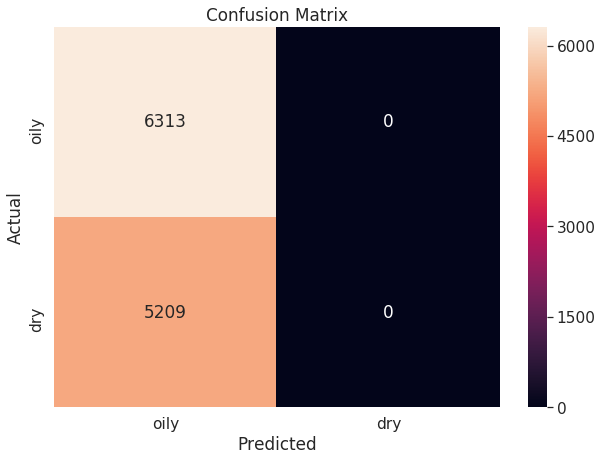

In [222]:
cm = confusion_matrix(y_test, y_pred_labels)
# flip confusion matrix, so that confusion matrix is properly ordered
cm_flip = np.flip(cm, 0)
cm_flip = np.flip(cm_flip, 1)
df_cm = pd.DataFrame(cm_flip, index=('oily', 'dry'), columns=('oily', 'dry'))

fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

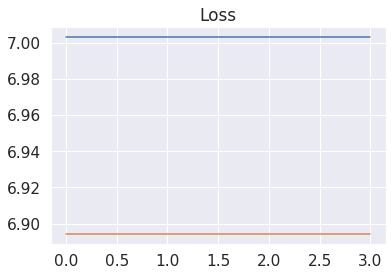

In [228]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

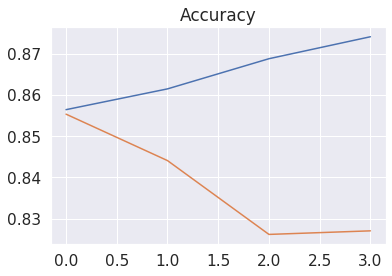

In [249]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')

### LSTM Model2

In [41]:
# LSTM model2
model = Sequential()
# embedding layer in which words are encoded as real-valued vectors and where similarity between words is translated to closeness in vector space
model.add(Embedding(max_nb_words, embedding_dim, input_length=X.shape[1]))
# whole feature map may be dropped out, prevents co-adaptation of feature & its neighbors
model.add(SpatialDropout1D(0.4))
# LSTM layer with 10 memory units
model.add(LSTM(100, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))
# added dropout
model.add(SpatialDropout1D(0.4))
model.add(LSTM(100, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 93, 8)             40000     
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 93, 8)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 93, 100)           43600     
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 93, 100)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 164,101
Trainable params: 164,101
Non-trainable params: 0
________________________________________________

In [42]:
# fit LSTM model2
history = model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_test, y_test),
                   callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 41476 samples, validate on 4609 samples
Epoch 1/10
41476/41476 [==============================] - 221s 5ms/sample - loss: 0.6031 - accuracy: 0.6477 - val_loss: 0.4966 - val_accuracy: 0.7355
Epoch 2/10
41476/41476 [==============================] - 218s 5ms/sample - loss: 0.5177 - accuracy: 0.7272 - val_loss: 0.4720 - val_accuracy: 0.7494
Epoch 3/10
41476/41476 [==============================] - 207s 5ms/sample - loss: 0.4844 - accuracy: 0.7474 - val_loss: 0.4692 - val_accuracy: 0.7481
Epoch 4/10
41476/41476 [==============================] - 162s 4ms/sample - loss: 0.4758 - accuracy: 0.7530 - val_loss: 0.4660 - val_accuracy: 0.7522
Epoch 5/10
41476/41476 [==============================] - 162s 4ms/sample - loss: 0.4632 - accuracy: 0.7589 - val_loss: 0.4759 - val_accuracy: 0.7579
Epoch 6/10
41476/41476 [==============================] - 159s 4ms/sample - loss: 0.4580 - accuracy: 0.7639 - val_loss: 0.4656 - val_accuracy: 0.7568
Epoch 7/10
41476/41476 [===========================

In [43]:
y_pred = model.predict(X_test)
acc = model.evaluate(X_test, y_test)
print('Accuracy: ', (acc[1] * 100))

4609/4609 [==============================] - 8s 2ms/sample - loss: 0.4605 - accuracy: 0.7605
Accuracy:  76.04686617851257


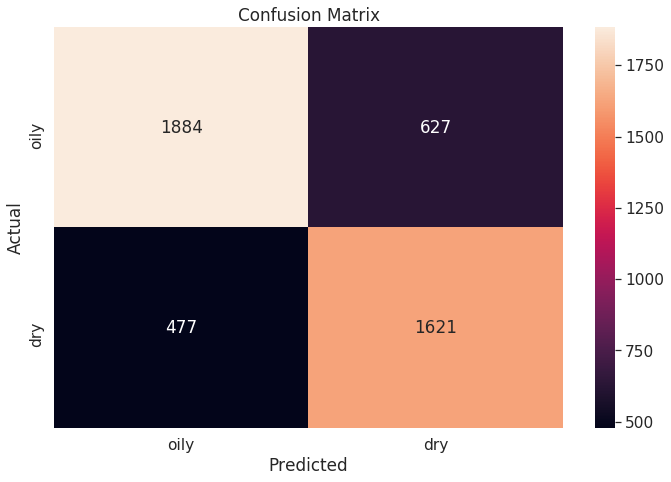

In [44]:
# convert predicted values from probabilities to labels
y_pred_labels = (y_pred > 0.5).astype(np.int)

cm = confusion_matrix(y_test, y_pred_labels)
# flip confusion matrix, so that confusion matrix is properly ordered
cm_flip = np.flip(cm, 0)
cm_flip = np.flip(cm_flip, 1)
df_cm = pd.DataFrame(cm_flip, index=('oily', 'dry'), columns=('oily', 'dry'))

fig, ax = plt.subplots(figsize=(10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

plt.tight_layout()
# plt.savefig('imgs/Model13_cm.png')

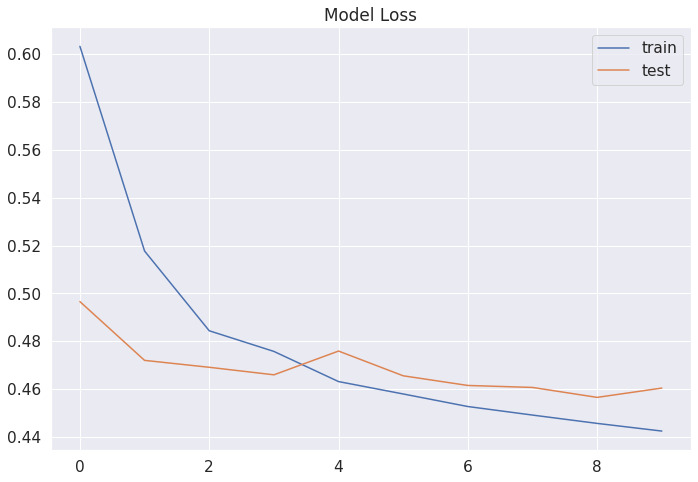

In [45]:
fig, ax = plt.subplots(figsize=(10,7))
plt.title('Model Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.tight_layout()
# plt.savefig('imgs/Model13_Loss.png')

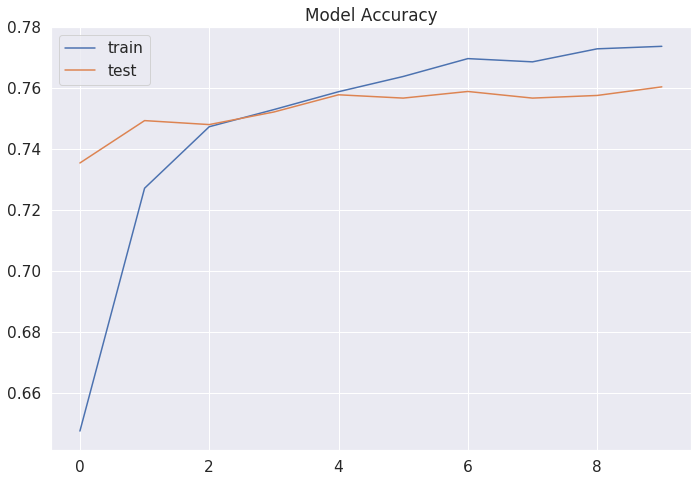

In [46]:
fig, ax = plt.subplots(figsize=(10,7))
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()

plt.tight_layout()
# plt.savefig('imgs/Model13_Acc.png')

In [239]:
# save model to file
# model.save('models/model13.h5')

In [64]:
model4 = load_model('models/model4.h5')
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 481, 32)           640000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 481, 32)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 481, 100)          53200     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 773,701
Trainable params: 773,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# LSTM model2
model = Sequential()
# embedding layer in which words are encoded as real-valued vectors and where similarity between words is translated to closeness in vector space
model.add(Embedding(max_nb_words, embedding_dim, input_length=X.shape[1]))
# whole feature map may be dropped out, prevents co-adaptation of feature & its neighbors
model.add(SpatialDropout1D(0.2))
# LSTM layer with 100 memory units
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
# Build the model
print('Build model...')
model = Sequential()
model.add(LSTM(100, return_sequences=False, input_length=X.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(units=output_labels))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

batch_size=1000
model.fit(train_x, train_y, batch_size=batch_size, epochs=10, validation_data=(validate_x, validate_y))

## LSTM Model with Undersampling for all 4 Classes

In [88]:
# max number of most frequent words
max_nb_words = 20000
# max number of words in each review, longest review is 481 sentences
max_seq_length = 481
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_nb_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(model_df['review_text'].values)
word_index = tokenizer.word_index
print('Found {} unique tokens'.format(len(word_index)))

Found 33091 unique tokens


In [89]:
X = tokenizer.texts_to_sequences(model_df['review_text'].values)
# pad sequences vectorizes and creates a uniform length of sentences
X = pad_sequences(X, maxlen=max_seq_length)
print('Shape of data tensor: ', X.shape)

Shape of data tensor:  (134442, 481)


In [98]:
# create bag of words list to use for columns in dataframe
bow = list(word_index.keys())
bow_481 = list(word_index.keys())[:481]
len(bow)

33091

In [99]:
y = pd.get_dummies(model_df['skin_type']).values
print('Shape of label tensor: ', y.shape)

Shape of label tensor:  (134442, 4)


In [100]:
# split data into training and testing set to create holdout test set and balanced training data
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.25, random_state=42)

In [101]:
print('Combination: ', X_train1[y_train1[:, 0] == 1].shape)
print('Oily: ', X_train1[y_train1[:, 1] == 1].shape)
print('Dry: ', X_train1[y_train1[:, 2] == 1].shape)
print('Normal: ', X_train1[y_train1[:, 3] == 1].shape)

Combination:  (53128, 481)
Oily:  (15783, 481)
Dry:  (13165, 481)
Normal:  (18755, 481)


In [102]:
X_train1.shape

(100831, 481)

In [103]:
y_train1.shape

(100831, 4)

In [104]:
# column_names = ['word ' + str(num) for num in range(1, 482)]

In [105]:
# df_train1 = pd.DataFrame(X_train1, columns=column_names)
# df_train2 = pd.DataFrame(y_train1, columns=['Combination', 'Oily', 'Dry', 'Normal'])
# df_train_final = pd.concat([df_train1, df_train2], axis=1)
# df_train_final.head()

In [106]:
df_train1 = pd.DataFrame(X_train1, columns=bow_481)
df_train2 = pd.DataFrame(y_train1, columns=['Combination', 'Oily', 'Dry', 'Normal'])
df_train_final = pd.concat([df_train1, df_train2], axis=1)
df_train_final.head()

,foundation,skin,coverage,like,love,product,it,day,oily,face,...,difficult,due,scent,seem,own,says,Combination,Oily,Dry,Normal
0,0,0,0,0,0,0,0,0,0,0,...,7,258,394,7,36,12887,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,38,329,60,57,209,375,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1279,225,58,5,5,5,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,28,5,34,156,13259,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,52,62,80,154,4314,209,1,0,0,0


In [107]:
# separate majority and minority class
majority_class = df_train_final[df_train_final['Combination'] == 1]
minority_class = df_train_final[df_train_final['Normal'] == 1]

In [108]:
# downsample majority class
majority_downsampled = resample(majority_class, 
                                replace=False,
                               n_samples=18755,
                               random_state=123)
majority_downsampled.shape

(18755, 485)

In [109]:
majority_downsampled.head()

,foundation,skin,coverage,like,love,product,it,day,oily,face,...,difficult,due,scent,seem,own,says,Combination,Oily,Dry,Normal
25069,0,0,0,0,0,0,0,0,0,0,...,6,135,222,1061,714,250,1,0,0,0
78446,0,0,0,0,0,0,0,0,0,0,...,33,62,54,150,38,64,1,0,0,0
68796,0,0,0,0,0,0,0,0,0,0,...,532,277,131,133,21,9,1,0,0,0
35690,0,0,0,0,0,0,0,0,0,0,...,511,176,484,950,630,160,1,0,0,0
51975,0,0,0,0,0,0,0,0,0,0,...,27,6854,2998,2028,468,25,1,0,0,0


In [110]:
# combine downsample majority class with remaining training set
X_train_ds = pd.concat([majority_downsampled,
                       df_train_final[df_train_final['Oily'] == 1]],
                      axis=0)
X_train_ds2 = pd.concat([X_train_ds,
                       df_train_final[df_train_final['Dry'] == 1]],
                      axis=0)
X_train_ds_final = pd.concat([X_train_ds2,
                       df_train_final[df_train_final['Normal'] == 1]],
                      axis=0)
X_train_ds_final.shape

(66458, 485)

In [111]:
# redefine X and y for 2nd iteration of training and testing set split
X = X_train_ds_final.iloc[:, :-4].values
y = X_train_ds_final.iloc[:, -4:].values
print(X.shape)
print(y.shape)

(66458, 481)
(66458, 4)


In [112]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.25, random_state=42)

In [113]:
# LSTM model
model = Sequential()
# embedding layer in which words are encoded as real-valued vectors and where similarity between words is translated to closeness in vector space
model.add(Embedding(max_nb_words, embedding_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# add one more LSTM layer
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 481, 100)          2000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 481, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 2,080,804
Trainable params: 2,080,804
Non-trainable params: 0
_________________________________________________________________
None


In [114]:
#fit model
model.fit(X_train2, y_train2, batch_size=32, epochs=5)

Train on 49843 samples
Epoch 1/5
49843/49843 [==============================] - 1199s 24ms/sample - loss: 1.2638 - accuracy: 0.4013
Epoch 2/5
49843/49843 [==============================] - 4522s 91ms/sample - loss: 1.1979 - accuracy: 0.4503
Epoch 3/5
49843/49843 [==============================] - 1123s 23ms/sample - loss: 1.1419 - accuracy: 0.4854
Epoch 4/5
49843/49843 [==============================] - 1011s 20ms/sample - loss: 1.0839 - accuracy: 0.5234
Epoch 5/5
49843/49843 [==============================] - 1183s 24ms/sample - loss: 1.0339 - accuracy: 0.5514


In [115]:
y_pred = model.predict(X_test2)

In [116]:
acc = model.evaluate(X_test2, y_test2)
print('Accuracy: ', (acc[1] * 100))

16615/16615 [==============================] - 66s 4ms/sample - loss: 1.2107 - accuracy: 0.4462
Accuracy:  44.61631178855896


**predicting on holdout test set**

In [205]:
y_pred = model.predict(X_test1)

In [207]:
acc = model.evaluate(X_test1, y_test1)
print('Accuracy: ', (acc[1] * 100))

33611/33611 [==============================] - 66s 2ms/sample - loss: 1.2474 - accuracy: 0.4355


[1.247377719400625, 0.43554193]

### model tweaking

In [ ]:
# LSTM model2, tweak hyperparameters
embedding_dim = 32

model = Sequential()
# embedding layer in which words are encoded as real-valued vectors and where similarity between words is translated to closeness in vector space
model.add(Embedding(max_nb_words, embedding_dim, input_length=X.shape[1]))
# model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
#fit model2
model.fit(X_train2, y_train2, batch_size=64, epochs=3)

In [ ]:
# LSTM model3, tweak hyperparameters
embedding_dim = 32

model = Sequential()
# embedding layer in which words are encoded as real-valued vectors and where similarity between words is translated to closeness in vector space
model.add(Embedding(max_nb_words, embedding_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
#fit model3
model.fit(X_train2, y_train2, batch_size=64, epochs=3)